# Attempt 1

In [ ]:
import csv
from PIL import Image # pip install Pillow
import numpy as np
from matplotlib import pyplot
from os import path
import pandas as pd

In [ ]:
NUM_PEOPLE_TO_READ_IN = 100
TEST_RATIO = 0.20;

In [ ]:
data = {
    "images":np.empty((NUM_PEOPLE_TO_READ_IN*4,50,50,3)),
    "X":np.empty((NUM_PEOPLE_TO_READ_IN*4,50*50*3)),
    "Y":np.empty((NUM_PEOPLE_TO_READ_IN*4))
}

counter = 0
with open('metadata.csv', newline='') as csvfile:
    rows = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in tuple(rows)[1:]:
        
        mask_type = int(row[1])
        filename = row[5]
        
        try:
            image = np.array(Image.open(path.join("data", filename))) / 255.0
        except FileNotFoundError:
            image = np.zeros([50,50,3]) # USED FOR DISPLAYING NICELY BELOW / TODO: MAKE SURE TO FILTER THESE AT SOME POINT
            
        data["images"][counter] = image
        data["X"][counter] = np.reshape(image, 50*50*3)
        data["Y"][counter] = mask_type
        
        counter += 1
        if(counter >= NUM_PEOPLE_TO_READ_IN*4):
            break
            
    data["images"] = data["images"]
    data["X"] = data["X"]
    data["Y"] = data["Y"].astype("int")

In [ ]:
print(data["images"].shape)
print(data["X"].shape)
print(data["Y"].shape)

In [ ]:
pd.DataFrame(data["X"])

In [ ]:
pd.DataFrame(data["Y"], columns=np.array(["Y"]))

In [ ]:
# Maximum of 10000 people (~240MB for .ipynb file) for full dataset
# Maximum of about 1045 people (25MB for .ipynb file) for Jupyter Notebook
# Maximum of about 4180 people (100MB for .ipynb file) for github upload
NUM_PEOPLE_TO_PLOT=100

In [ ]:
pyplot.figure(figsize=(4, NUM_PEOPLE_TO_PLOT))
counter = 0
for img in data["images"]:
    pyplot.subplot(NUM_PEOPLE_TO_PLOT, 4, counter+1)
    pyplot.axis("off")
    pyplot.imshow(img)
    counter += 1
    if(counter >= NUM_PEOPLE_TO_PLOT):
        break;
    

In [ ]:
shuffler = np.random.permutation(NUM_PEOPLE_TO_READ_IN)

cut_index = int(NUM_PEOPLE_TO_READ_IN*TEST_RATIO)

x_scaled = data["X"]*2-1

x_shuffled = x_scaled[shuffler]
y_shuffled = data["Y"][shuffler]

x_train = x_shuffled[cut_index:]
x_test = x_shuffled[0:cut_index]

y_train = y_shuffled[cut_index:]
y_test = y_shuffled[0:cut_index]


In [ ]:
print(data["images"].shape)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

# Attempt 2

## Source: https://www.tensorflow.org/tutorials/images/classification

In [1]:
import tensorflow as tf
from matplotlib import pyplot
import numpy as np

2021-10-25 17:03:13.266079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-25 17:03:13.266107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 39698 files belonging to 4 classes.
Using 31759 files for training.


2021-10-25 17:03:20.765701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-25 17:03:20.765730: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-25 17:03:20.765775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (benjamin-XPS-13-9370): /proc/driver/nvidia/version does not exist
2021-10-25 17:03:20.766121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory("data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 39698 files belonging to 4 classes.
Using 7939 files for validation.


In [4]:
class_names = ["1","2","3","4"]

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
num_classes = 4

model =  tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2021-10-25 17:03:40.341397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


993/993 [==============================] - 45s 43ms/step - loss: 0.8477 - accuracy: 0.6311 - val_loss: 0.6692 - val_accuracy: 0.7331
Epoch 2/10
993/993 [==============================] - 42s 42ms/step - loss: 0.5601 - accuracy: 0.7802 - val_loss: 0.5064 - val_accuracy: 0.8078
Epoch 3/10
993/993 [==============================] - 42s 42ms/step - loss: 0.4510 - accuracy: 0.8282 - val_loss: 0.4345 - val_accuracy: 0.8381
Epoch 4/10
993/993 [==============================] - 41s 42ms/step - loss: 0.3840 - accuracy: 0.8548 - val_loss: 0.4174 - val_accuracy: 0.8400
Epoch 5/10
993/993 [==============================] - 46s 47ms/step - loss: 0.3356 - accuracy: 0.8716 - val_loss: 0.3969 - val_accuracy: 0.8582
Epoch 6/10
993/993 [==============================] - 42s 42ms/step - loss: 0.2930 - accuracy: 0.8872 - val_loss: 0.3929 - val_accuracy: 0.8617
Epoch 7/10
993/993 [==============================] - 42s 42ms/step - loss: 0.2488 - accuracy: 0.9054 - val_loss: 0.3903 - val_accuracy: 0.8608
Epo

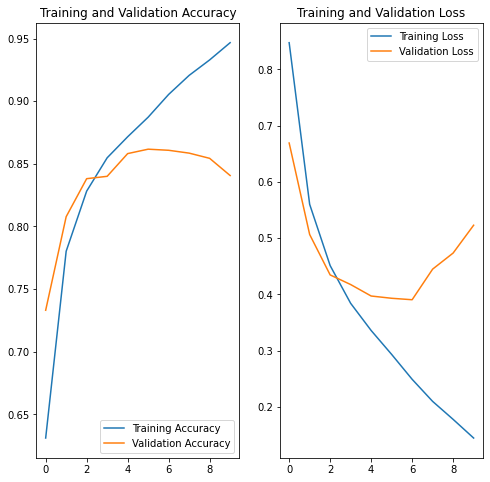

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [12]:
def predict(file_path):

    img = tf.keras.utils.load_img(file_path, target_size=(50, 50))
    pyplot.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])


    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )


This image most likely belongs to 1 with a 97.81 percent confidence.


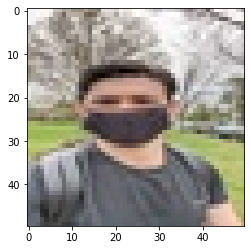

In [13]:
predict("/home/benjamin/Downloads/PXL_20210428_170036656_reduced.jpg")

This image most likely belongs to 1 with a 44.86 percent confidence.


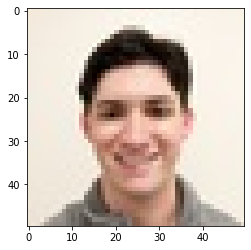

In [14]:
predict("/home/benjamin/Downloads/IMG_20200113_085742_reduced.jpg")